In [1]:
import warnings
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'

warnings.filterwarnings('ignore', category = RuntimeWarning)

RANDOM_STATE = 50
EPOCHS = 150
BATCH_SIZE = 2048
TRAINING_LENGTH = 50
TRAIN_FRACTION = 0.7
LSTM_CELLS = 64
VERBOSE = 0
SAVE_MODEL = True

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11677381950414855908
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 17537348918120873604
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1
]


2024-01-21 11:57:52.235610: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-01-21 11:57:52.235630: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-01-21 11:57:52.235634: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-01-21 11:57:52.235664: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-21 11:57:52.235676: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## read in data 

In [3]:
import pandas as pd
import numpy as np

In [4]:
data = pd.read_csv('/Users/jiashu/Downloads/neural_network_patent_query.csv', parse_dates = ['patent_date'])

In [5]:
data.head()

,patent_abstract,patent_date,patent_number,patent_title
0,""" A """"Barometer"""" Neuron enhances stability in...",1996-07-09,5535303,"""""""Barometer"""" neuron for a neural network"""
1,""" This invention is a novel high-speed neural ...",1993-10-19,5255349,"""Electronic neural network for solving """"trave..."
2,An optical information processor for use as a ...,1995-01-17,5383042,3 layer liquid crystal neural network with out...
3,A method and system for intelligent control of...,2001-01-02,6169981,3-brain architecture for an intelligent decisi...
4,A method and system for intelligent control of...,2003-06-17,6581048,3-brain architecture for an intelligent decisi...


In [6]:
original_abstracts = list(data['patent_abstract'])

In [7]:
len(original_abstracts)

3522

## data exploration

In [8]:
data['patent_abstract'][100]

'The present invention provides an apparatus and a method for classifying and recognizing image patterns using a second-order neural network, thereby achieving high-rate parallel processing while lowering the complexity. The second-order neural network, which is made of adders and multipliers, corrects positional translations generated in a complex-log mapping unit to output the same result for the same object irrespective of the scale and/or rotation of the object. The present invention enables high-rate image pattern classification and recognition based on parallel processing, which is the advantage obtained in neural network models, because consistent neural networks and consistent network structure computation models are applied to all steps from the image input step to the pattern classifying and recognizing step.'

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
plt.style.use('fivethirtyeight')

In [11]:
data['year_month'] = pd.to_datetime([f"{y}-{m}-1" for y, m in zip(
        data['patent_date'].dt.year, data['patent_date'].dt.month)])

In [12]:
monthly = data.groupby(['year_month'])['patent_number'].count().reset_index()

In [13]:
monthly

,year_month,patent_number
0,1978-06-01,1
1,1985-08-01,1
2,1986-06-01,1
3,1987-10-01,2
4,1988-04-01,1
...,...,...
349,2018-01-01,29
350,2018-02-01,20
351,2018-03-01,13
352,2018-04-01,30


<Axes: xlabel='year_month'>

Text(0, 0.5, 'Number of Patents')

Text(0.5, 0, 'Date')

Text(0.5, 1.0, 'Neural Network Patents Over Time')

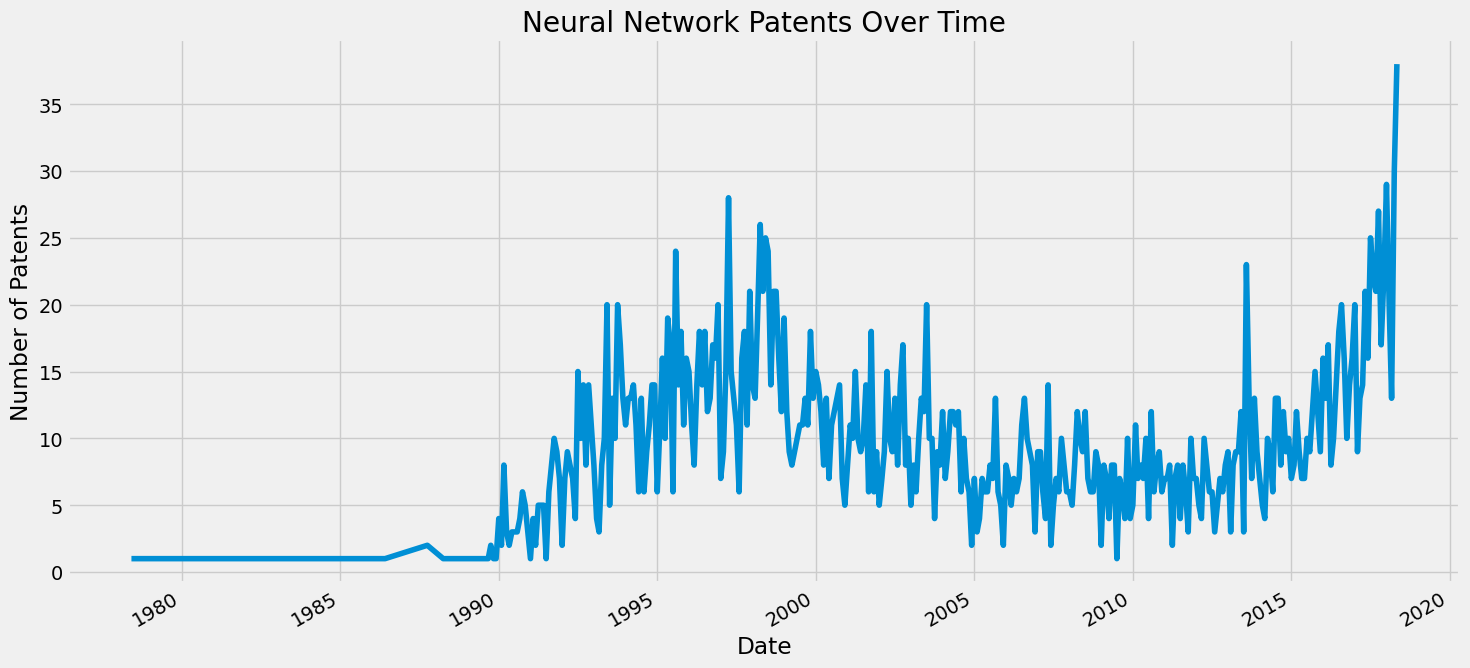

In [14]:
monthly.set_index('year_month')['patent_number'].plot(figsize = (16, 8))
plt.ylabel('Number of Patents')
plt.xlabel('Date')
plt.title('Neural Network Patents Over Time')

<Axes: xlabel='year_month'>

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Number of Patents')

Text(0.5, 1.0, 'Neural Network Patents by Year')

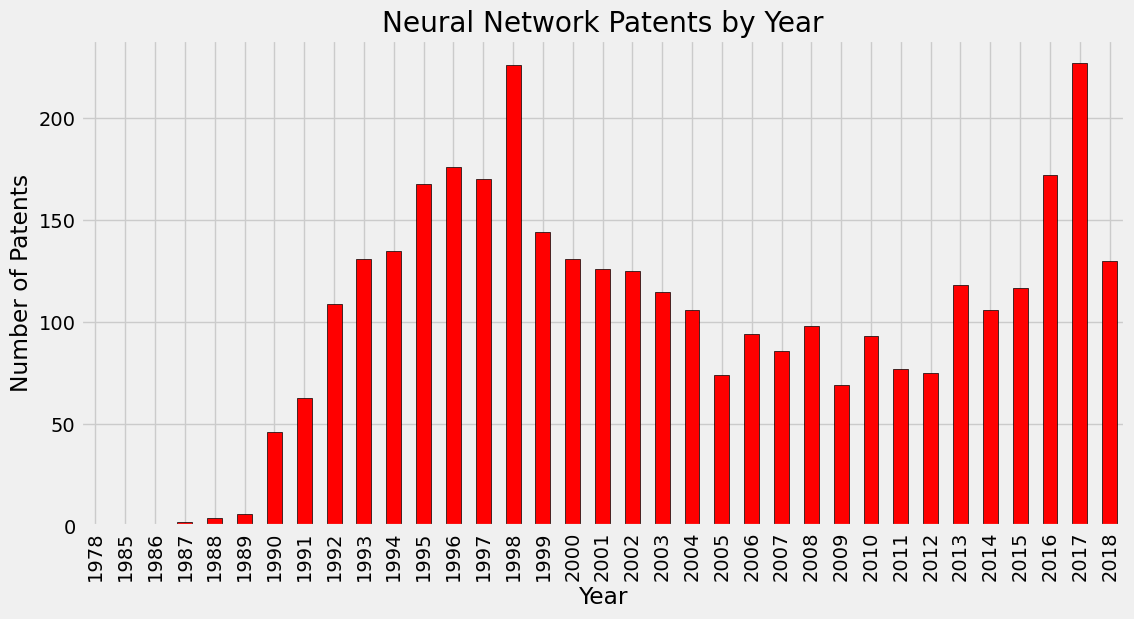

In [15]:
monthly.groupby(monthly['year_month'].dt.year)['patent_number'].sum().plot.bar(
    color = 'red', edgecolor = 'k', figsize = (12, 6)
)
plt.xlabel('Year')
plt.ylabel('Number of Patents')
plt.title("Neural Network Patents by Year")

## data cleaning

In [16]:
from keras.preprocessing.text import Tokenizer

In [17]:
example = 'This is a short sentence (1) with one reference to an image. This next sentence, \
while non-sensical, does not have an image and has two commas.'
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')

In [18]:
tokenizer.fit_on_texts([example])

In [19]:
s = tokenizer.texts_to_sequences([example])[0]

In [20]:
' '.join(tokenizer.index_word[i] for i in s)

'this is a short sentence 1 with one reference to an image this next sentence while non sensical does not have an image and has two commas'

In [21]:
print(tokenizer.word_index)

{'this': 1, 'sentence': 2, 'an': 3, 'image': 4, 'is': 5, 'a': 6, 'short': 7, '1': 8, 'with': 9, 'one': 10, 'reference': 11, 'to': 12, 'next': 13, 'while': 14, 'non': 15, 'sensical': 16, 'does': 17, 'not': 18, 'have': 19, 'and': 20, 'has': 21, 'two': 22, 'commas': 23}


In [22]:
tokenizer = Tokenizer(filters='!"#$%&*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts([example])
s = tokenizer.texts_to_sequences([example])[0]
' '.join(tokenizer.index_word[i] for i in s)

'this is a short sentence (1) with one reference to an image this next sentence while non sensical does not have an image and has two commas'

In [23]:
print(tokenizer.word_index)

{'this': 1, 'sentence': 2, 'an': 3, 'image': 4, 'is': 5, 'a': 6, 'short': 7, '(1)': 8, 'with': 9, 'one': 10, 'reference': 11, 'to': 12, 'next': 13, 'while': 14, 'non': 15, 'sensical': 16, 'does': 17, 'not': 18, 'have': 19, 'and': 20, 'has': 21, 'two': 22, 'commas': 23}


In [24]:
import re


def format_patent(patent):
    
    # Add spaces around punctuation
    patent = re.sub(r'(?<=[^\s0-9])(?=[.,;?])', r' ', patent)

    # Remove references to figures
    patent = re.sub(r'\((\d+)\)', r'', patent)

    # Remove double spaces
    patent = re.sub(r'\s\s', ' ', patent)
    return patent

In [25]:
f = format_patent(example)
f

'This is a short sentence with one reference to an image . This next sentence , while non-sensical , does not have an image and has two commas .'

In [26]:
formatted = []

for a in original_abstracts:
    formatted.append(format_patent(a))

len(formatted)

3522

## convert text into sequences

In [27]:
def make_sequences(texts,
                  training_length = 50,
                  lower = True,
                  filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
    """Turn a set of texts into sequences of intergers"""
    
    # create the tokenizer object and train on texts
    tokenizer = Tokenizer(lower = lower, filters = filters)
    tokenizer.fit_on_texts(texts)
    
    # create look-up dictionary and reverse look-ups
    word_idx = tokenizer.word_index
    idx_word = tokenizer.index_word
    num_words = len(word_idx) + 1
    word_counts = tokenizer.word_counts
    
    print(f'there are {num_words} unique words.')
    
    # convert text to sequences of integers
    sequences = tokenizer.texts_to_sequences(texts)
    
    # limit to sequences with more than training length tokens
    seq_lengths = [len(x) for x in sequences]
    over_idx = [
        i for i, l in enumerate(seq_lengths) if l > (training_length + 20)
    ]
    
    new_texts = []
    new_sequences = []
    
    # only keep sequences  with more than training length tokens
    for i in over_idx:
        new_texts.append(texts[i])
        new_sequences.append(sequences[i])
    
    training_seq = []
    labels = []
    
    # iterate through the sequence of tokens
    for seq in new_sequences:
        
        # create multiple training examples from each sequence
        for i in range(training_length, len(seq)):
            # extract te feature and label
            extract = seq[i - training_length: i+1]
            
            training_seq.append(extract[:-1])
            labels.append(extract[-1])
            
    print(f"there are {len(training_seq)} training sequences.")
    
    return word_idx, idx_word, num_words, word_counts, new_texts, new_sequences, training_seq, labels    

In [28]:
TRAINING_LENGTH = 50
filters = '!"#$%&()*+/:<=>@[\\]^_`{|}~\t\n'
word_idx, idx_word, num_words, word_counts, abstracts, sequences, features, labels = make_sequences(
    formatted, TRAINING_LENGTH, lower = True, filters = filters
)

there are 13677 unique words.
there are 320881 training sequences.


In [29]:
n = 3
features[n][:10]

[3086, 1978, 11, 2, 9, 8, 19, 27, 5, 117]

In [30]:
def find_answer(index):
    """find label corresponding to features for index in training data"""
    
    feats = ' '.join(idx_word[i] for i in features[index])
    answer = idx_word[labels[index]]
    
    print('Features:', feats)
    print("\nLabel:", answer)

In [31]:
find_answer(n)

Features: enhances stability in a neural network system that , when used as a track-while-scan system , assigns sensor plots to predicted track positions in a plot track association situation . the barometer neuron functions as a bench-mark or reference system node that equates a superimposed plot and track to a

Label: zero


In [32]:
original_abstracts[0]

'" A ""Barometer"" Neuron enhances stability in a Neural Network System that, when used as a track-while-scan system, assigns sensor plots to predicted track positions in a plot/track association situation. The ""Barometer"" Neuron functions as a bench-mark or reference system node that equates a superimposed plot and track to a zero distance as a ""perfect"" pairing of plot and track which has a measured/desired level of inhibition. The ""Barometer"" Neuron responds to the System inputs, compares these inputs against the level of inhibition of the ""perfect"" pair, and generates a supplied excitation or inhibition output signal to the System which adjusts the System to a desired value at or near 1.0; this the reference level of inhibition of the ""perfect"" pair. "'

In [33]:
sorted(word_counts.items(), key = lambda x: x[1], reverse = True)[:15]

[('the', 36597),
 ('a', 24883),
 ('of', 20193),
 ('.', 16604),
 (',', 15417),
 ('and', 12947),
 ('to', 12073),
 ('network', 7733),
 ('neural', 7381),
 ('is', 7213),
 ('in', 6992),
 ('for', 6907),
 ('an', 6061),
 ('data', 4010),
 ('by', 3607)]

## training data

In [34]:
from sklearn.utils import shuffle
import gc

In [35]:
def create_train_valid(features,
                      labels,
                      num_words,
                      train_fraction = TRAIN_FRACTION):
    """create training and validation features and labels"""
    
    # randomly shuffle features and labels
    features, labels = shuffle(features, labels, random_state = RANDOM_STATE)
    
    # decide on number of samples for training
    train_end = int(train_fraction * len(labels))
    
    train_features = np.array(features[:train_end])
    valid_features = np.array(features[train_end:])
    
    train_labels = labels[:train_end]
    valid_labels = labels[train_end:]
    
    # convert to arrays
    X_train, X_valid = np.array(train_features), np.array(valid_features)
    
    # using int8 for memory savings
    y_train = np.zeros((len(train_labels), num_words), dtype = np.int8)
    y_valid = np.zeros((len(valid_labels), num_words), dtype = np.int8)
    
    # one hot encoding of labels
    for example_index, word_index in enumerate(train_labels):
        y_train[example_index, word_index] = 1
    
    for example_index, word_index in enumerate(valid_labels):
        y_valid[example_index, word_index] = 1
    
    # memory management
    gc.enable()
    del features, labels, train_features, valid_features, train_labels, valid_labels
    gc.collect()
    
    return X_train, X_valid, y_train, y_valid

In [36]:
X_train, X_valid, y_train, y_valid = create_train_valid(
    features, labels, num_words)

X_train.shape
y_train.shape

(224616, 50)

(224616, 13677)

In [37]:
import sys

sys.getsizeof(y_train)/ 1e9

3.07207316

In [38]:
def check_sizes(gb_min = 1):
    for x in globals():
        size = sys.getsizeof(eval(x)) / 1e9
        if size > gb_min:
            print(f"object: {x:10}\t Size: {size} GB.")

In [39]:
check_sizes(gb_min = 1)

object: y_train   	 Size: 3.07207316 GB.
object: y_valid   	 Size: 1.316616533 GB.


## pre_trained embeddings

In [40]:
import os
from keras.utils import get_file

In [41]:
glove_vectors = '/Users/jiashu/Documents/data/glove.6B/glove.6B.100d.txt'

In [42]:
glove = np.loadtxt(glove_vectors, dtype = 'str', comments = None)
glove.shape

(400000, 101)

In [43]:
vectors = glove[:, 1:].astype('float')
words = glove[:, 0]

del glove

vectors[100], words[100]

(array([-3.9551e-01,  5.4660e-01,  5.0315e-01, -6.3682e-01, -4.5470e-01,
         3.0889e-01, -4.9240e-02,  2.7191e-01,  3.1562e-01, -3.2879e-01,
         2.5089e-01,  1.4508e-01,  3.5136e-01, -2.2793e-01, -1.5894e-01,
        -5.1527e-01, -2.7978e-01,  3.6470e-01, -3.9425e-01,  3.3299e-01,
         4.3051e-01,  1.8300e-01,  2.5095e-01, -1.8547e-01,  3.4698e-01,
         5.5137e-02, -4.5979e-01, -8.2963e-01, -1.8523e-02, -3.6772e-01,
         4.5566e-02,  7.1052e-01, -2.2782e-02, -8.0889e-02,  2.0685e-01,
         4.9855e-01, -5.9794e-02, -8.0048e-03, -2.3823e-01, -3.3759e-01,
        -2.4201e-01, -2.3788e-01, -1.1362e-03, -4.0395e-01, -4.4859e-01,
        -3.2189e-01,  4.8405e-01, -2.7999e-02,  1.0148e-01, -9.3585e-01,
        -8.7522e-02, -3.9959e-01,  3.6545e-01,  1.3726e+00, -3.0713e-01,
        -2.5940e+00,  2.2431e-01, -4.1168e-02,  1.7765e+00,  4.0010e-01,
        -1.0996e-01,  1.4178e+00, -2.6154e-01,  1.8617e-01,  7.9328e-01,
        -1.1709e-01,  8.7541e-01,  4.3911e-01,  3.4

In [44]:
vectors.shape

(400000, 100)

In [45]:
word_lookup = {word: vector for word, vector in zip(words, vectors)}

embedding_matrix = np.zeros((num_words, vectors.shape[1]))

not_found = 0

for i, word in enumerate(word_idx.keys()):
    # look up the word embeddings
    vector = word_lookup.get(word, None)
    
    if vector is not None:
        embedding_matrix[i+1, :] = vector
    else:
        not_found += 1

print(f"There are {not_found} words without pretrained embeddings.")

There are 2941 words without pretrained embeddings.


In [46]:
gc.enable()
del vectors
gc.collect()

0

In [47]:
# normalize each row and convert nan to 0

embedding_matrix = embedding_matrix /\
    np.linalg.norm(embedding_matrix, axis = 1).reshape((-1, 1))

embedding_matrix = np.nan_to_num(embedding_matrix)

In [48]:
def find_closest(query, embedding_matrix, word_idx, idx_word, n = 10):
    """find closest words to a query word in embeddings"""
    
    idx = word_idx.get(query, None)
    if idx is None:
        print(f"{query} not found in vocab")
        return
    else:
        vec = embedding_matrix[idx]
        # handle cases where word does not have an embedding
        if np.all(vec == 0):
            print(f"{query} has no_pretrained embeddings")
        else:
            # calculate distances between vector and all others
            dists = np.dot(embedding_matrix, vec)
            
            # sort indexes in reverse order
            idxs = np.argsort(dists)[::-1][:n]
            sorted_dists = dists[idxs]
            closest = [idx_word[i] for i in idxs]
    print(f"Query: {query} \n")
    max_len = max([len(i) for i in closest])
    # print out the word and cosine distances
    for word, dist in zip(closest, sorted_dists):
        print(f"word: {word:15} Cosine Similarity: {round(dist, 4)}")

In [49]:
find_closest('the', embedding_matrix, word_idx, idx_word)   

Query: the 

word: the             Cosine Similarity: 1.0
word: this            Cosine Similarity: 0.8573
word: part            Cosine Similarity: 0.8508
word: one             Cosine Similarity: 0.8503
word: of              Cosine Similarity: 0.8329
word: same            Cosine Similarity: 0.8325
word: first           Cosine Similarity: 0.821
word: on              Cosine Similarity: 0.82
word: its             Cosine Similarity: 0.8169
word: as              Cosine Similarity: 0.8128


In [50]:
find_closest('neural', embedding_matrix, word_idx, idx_word)   

Query: neural 

word: neural          Cosine Similarity: 1.0
word: neuronal        Cosine Similarity: 0.6841
word: cortical        Cosine Similarity: 0.676
word: plasticity      Cosine Similarity: 0.6625
word: pathways        Cosine Similarity: 0.6534
word: neurons         Cosine Similarity: 0.6485
word: sensory         Cosine Similarity: 0.6391
word: cognitive       Cosine Similarity: 0.6125
word: brain           Cosine Similarity: 0.6082
word: physiological   Cosine Similarity: 0.6022


## build model

In [51]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam
from keras.utils import plot_model

In [52]:
def make_word_level_model(num_words,
                         embedding_matrix,
                         lstm_cells = 64,
                         trainable = False,
                         lstm_layers = 1,
                         bi_direc = False):
    
    model = Sequential()
    
    # map words to an embedding
    if not trainable:
        model.add(
            Embedding(
                input_dim = num_words,
                output_dim = embedding_matrix.shape[1],
                weights = [embedding_matrix],
                trainable = False,
                mask_zero = True))
        model.add(Masking())
    else:
        model.add(
            Embedding(
                input_dim = num_words,
                output_dim = embedding_matrix.shape[1],
                weights = [embedding_matrix],
                trainable = True))
    
    # if want to add multiple lstm layers
    if lstm_layers > 1:
        for i in range(lstm_layers - 1):
            model.add(
                LSTM(
                    lstm_cells, 
                    return_sequences = True,
                    dropout = 0.1,
                    recurrent_dropout = 0.1))
    
    # add final lstm cell layer
    if bi_direc:
        model.add(
            Bidirectional(
                LSTM(
                    lstm_cells,
                    return_sequences = False, 
                    dropout = 0.1,
                    recurrent_dropout = 0.1)))
    else:
        model.add(
            LSTM(
                lstm_cells, 
                return_sequences = False,
                dropout = 0.1,
                recurrent_dropout = 0.1))
    
    model.add(Dense(128, activation = 'relu'))
    
    # dropout for regularization
    model.add(Dropout(0.5))
    
    # output layer
    model.add(Dense(num_words, activation = 'softmax'))
    
    # compile the model
    model.compile(
        optimizer = 'adam',
        loss = 'categorical_crossentropy',
        metrics = ['accuracy']
    )
    
    return model

In [53]:
model = make_word_level_model(
    num_words,
    embedding_matrix=embedding_matrix,
    lstm_cells = LSTM_CELLS,
    trainable = False,
    lstm_layers = 1
)

model.summary()

2024-01-21 11:58:12.799879: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-21 11:58:12.799902: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1367700   
                                                                 
 masking (Masking)           (None, None, 100)         0         
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 13677)             1764333   
                                                                 
Total params: 3182593 (12.14 MB)
Trainable params: 18148

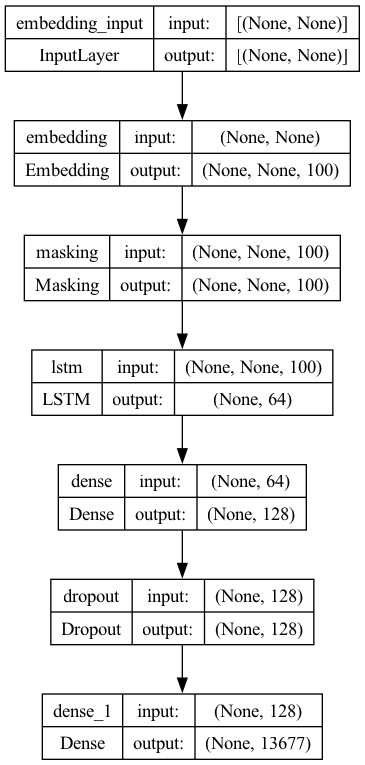

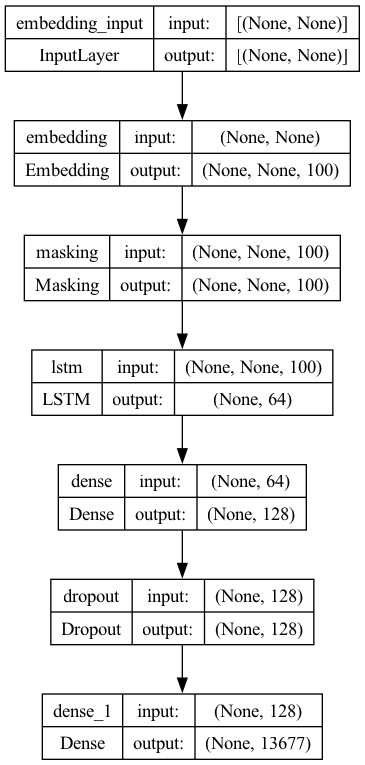

In [54]:
from IPython.display import Image

model_name = 'pre-trained-rnn'
model_dir = 'models/'

plot_model(model, to_file=f'{model_dir}{model_name}.png', show_shapes=True)

Image(f'{model_dir}{model_name}.png')

## train model

### callbacks

- early stopping: stop training when validation loss no longer decreases
- model checkpoint: save the best model on disk

In [56]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [57]:
BATCH_SIZE = 2048

In [58]:
def make_callbacks(model_name, save = SAVE_MODEL):
    callbacks = [EarlyStopping(monitor = 'val_loss', patience = 5)]
    
    if save:
        callbacks.append(
            ModelCheckpoint(
                f'{model_dir}{model_name}.h5',
                save_best_only = True,
                save_weights_only = False
            )
        )
    return callbacks

callbacks = make_callbacks(model_name)

In [61]:
history = model.fit(
    X_train,
    y_train,
    epochs= 20,
    batch_size = BATCH_SIZE,
    verbose = 1,
    callbacks = callbacks,
    validation_data = (X_valid, y_valid)
)

Epoch 1/20
110/110 [==============================] - 587s 5s/step - loss: 6.6059 - accuracy: 0.0797 - val_loss: 6.2289 - val_accuracy: 0.0872
Epoch 2/20


/Users/jiashu/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 582s 5s/step - loss: 6.2246 - accuracy: 0.0863 - val_loss: 6.2095 - val_accuracy: 0.0872
Epoch 3/20
110/110 [==============================] - 585s 5s/step - loss: 6.1916 - accuracy: 0.0863 - val_loss: 6.1874 - val_accuracy: 0.0872
Epoch 4/20
110/110 [==============================] - 602s 5s/step - loss: 6.1353 - accuracy: 0.0915 - val_loss: 6.0834 - val_accuracy: 0.1012
Epoch 5/20
110/110 [==============================] - 598s 5s/step - loss: 6.0253 - accuracy: 0.1125 - val_loss: 5.9844 - val_accuracy: 0.1316
Epoch 6/20
110/110 [==============================] - 600s 5s/step - loss: 5.9349 - accuracy: 0.1292 - val_loss: 5.8888 - val_accuracy: 0.1435
Epoch 7/20
110/110 [==============================] - 600s 5s/step - loss: 5.8431 - accuracy: 0.1417 - val_loss: 5.8006 - val_accuracy: 0.1502
Epoch 8/20
110/110 [==============================] - 1745s 16s/step - loss: 5.7728 - accuracy: 0.1459 - val_loss: 5.7503 - val_accuracy: 0.1503
Epoch 9/

In [62]:
def load_and_evaluate(model_name, return_model = False):
    """load in a trained model and evaluate with log loss and accuracy"""
    
    model = load_model(f'{model_dir}{model_name}.h5')
    r = model.evaluate(X_valid, y_valid, batch_size = 2048, verbose = 1)
    
    valid_crossentropy = r[0]
    valid_accuracy = r[1]
    
    print(f"Cross Entropy: {round(valid_crossentropy, 4)}")
    print(f"Accuracy: {round(100 * valid_accuracy, 2)}%")
    
    if return_model:
        return model

In [63]:
model = load_and_evaluate(model_name, return_model = True)

48/48 [==============================] - 17s 352ms/step - loss: 5.4067 - accuracy: 0.1773
Cross Entropy: 5.4067
Accuracy: 17.73%


In [64]:
np.random.seed(40)

# number of all words
total_words = sum(word_counts.values())

frequencies = [word_counts[word]/total_words for word in word_idx.keys()]
frequencies.insert(0, 0)

In [65]:
frequencies[1:10], list(word_idx.keys())[0:9]

([0.07345992492824023,
  0.049946807442943456,
  0.040532728477087054,
  0.03332864971195729,
  0.030946024609084886,
  0.025988076838154118,
  0.024233726088440155,
  0.015522190328990947,
  0.014815632589975713],
 ['the', 'a', 'of', '.', ',', 'and', 'to', 'network', 'neural'])

In [66]:
print(
    f"the accuracy is {round(100 * np.mean(np.argmax(y_valid, axis = 1) == 1), 4)}"
)

the accuracy is 8.7207


In [67]:
random_guesses = []

# make a prediciton based on frequencies for each example in validation data
for i in range(len(y_valid)):
    random_guesses.append(
        np.argmax(np.random.multinomial(1, frequencies, size = 1)[0]))

In [68]:
from collections import Counter

c = Counter(random_guesses)

for i in c.most_common(10):
    word = idx_word[i[0]]
    word_count = word_counts[word]
    print(
        f'Word: {word} \tCount: {word_count} \tPercentage: {round(100 * word_count/total_words, 2)}%'
    )

Word: the 	Count: 36597 	Percentage: 7.35%
Word: a 	Count: 24883 	Percentage: 4.99%
Word: of 	Count: 20193 	Percentage: 4.05%
Word: . 	Count: 16604 	Percentage: 3.33%
Word: , 	Count: 15417 	Percentage: 3.09%
Word: and 	Count: 12947 	Percentage: 2.6%
Word: to 	Count: 12073 	Percentage: 2.42%
Word: network 	Count: 7733 	Percentage: 1.55%
Word: neural 	Count: 7381 	Percentage: 1.48%
Word: in 	Count: 6992 	Percentage: 1.4%


In [69]:
accuracy = np.mean(random_guesses == np.argmax(y_valid, axis = 1))
print(f"random guessing accuracy: {100 * round(accuracy, 4)}%")

random guessing accuracy: 1.54%


## generating output

In [70]:
from IPython.display import HTML

In [71]:
def header(text, color='black'):
    raw_html = f'<h1 style="color: {color};"><center>' + \
        str(text) + '</center></h1>'
    return raw_html


def box(text):
    raw_html = '<div style="border:1px inset black;padding:1em;font-size: 20px;">' + \
        str(text)+'</div>'
    return raw_html


def addContent(old_html, raw_html):
    old_html += raw_html
    return old_html

In [74]:
def remove_spaces(patent):
    """Remove spaces around punctuation"""
    patent = re.sub(r'\s+([.,;?])', r'\1', patent)

    return patent

In [75]:
import random

def generate_output(model,
                   sequences,
                   training_length = 50,
                   new_words = 50,
                   diversity = 1,
                   return_output = False,
                   n_gen = 1):
    
    # choose a random sequence
    seq = random.choice(sequences)
    
    # choose a random starting point
    seed_idx = random.randint(0, len(seq) - training_length - 10)
    
    # end index for seed
    end_idx = seed_idx + training_length
    
    gen_list = []
    
    for n in range(n_gen):
        
        # extract the seed sequence
        seed = seq[seed_idx : end_idx]
        original_sequence = [idx_word[i] for i in seed]
        generated = seed[:] + ['#']
        
        # find the actua entire sequence
        actual = generated[:] + seq[end_idx: end_idx+new_words]
        
        # keep adding new words
        for i in range(new_words):
            
            # make a prediction from the seed
            preds = model.predict(np.array(seed).reshape(1,-1))[0].astype(np.float64)
            
            # diversify
            preds = np.log(preds)/diversity
            exp_preds = np.exp(preds)
            
            # softmax
            preds = exp_preds/sum(exp_preds)
            
            # choose the next word
            probas = np.random.multinomial(1, preds, 1)[0]
            
            next_idx = np.argmax(probas)
            
            # new seed adds on old word
            seed = seed[1:] + [next_idx]
            generated.append(next_idx)
        
        # showing generated and actual abstract
        n = []
        
        for i in generated:
            n.append(idx_word.get(i, '<----->'))
        
        gen_list.append(n)
    
    a = []
    
    for i in actual:
        a.append(idx_word.get(i, '<----->'))
    
    a = a[training_length:]
    
    gen_list = [
        gen[training_length: training_length + len(a)] for gen in gen_list
    ]
    
    if return_output:
        return original_sequence, gen_list, a
    
    # HTML formatting
    seed_html = ''
    seed_html = addContent(seed_html, header(
        'Seed Sequence', color='darkblue'))
    seed_html = addContent(seed_html,
                           box(remove_spaces(' '.join(original_sequence))))

    gen_html = ''
    gen_html = addContent(gen_html, header('RNN Generated', color='darkred'))
    gen_html = addContent(gen_html, box(remove_spaces(' '.join(gen_list[0]))))

    a_html = ''
    a_html = addContent(a_html, header('Actual', color='darkgreen'))
    a_html = addContent(a_html, box(remove_spaces(' '.join(a))))
    
    return seed_html, gen_html, a_html

In [76]:
seed_html, gen_html, a_html = generate_output(model, sequences,
                                              TRAINING_LENGTH)
HTML(seed_html)
HTML(gen_html)
HTML(a_html)

1/1 [==============================] - 0s 220ms/step
